# Make ablated scene graphs

1. no attribute
2. no relation label (direct connection between objects)
3. random relation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import pickle
import pandas as pd
from tqdm import tqdm
import os
import copy

from dataloader import he_sampling
from data import FlickrDataset, CocoDataset, VGDataset
from PIL import Image
import matplotlib.patches as patches

from sklearn.feature_extraction.text import TfidfTransformer


# 1. no attribute

In [2]:
dataset = 'vg_coco'
if dataset == 'vg_coco':
    sg_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg.pkl'
    sg = pickle.load(open(sg_path, 'rb'))
    out_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg_noatt.pkl'

In [3]:
print(len(sg))
print(sg[0].keys())

48220
dict_keys(['obj_bboxes', 'obj_attributes', 'edge_labels', 'num_objs', 'num_rels', 'obj_labels', 'adj', 'node_labels', 'imgid'])


In [4]:
new_sg = copy.deepcopy(sg)

In [7]:
for i, sg_ in enumerate(tqdm(sg)):
    n_obj = len(sg_['obj_bboxes'])
    n_attr = len(sg_['obj_attributes'])
    
    a = np.delete(sg_['adj'], np.s_[n_obj:n_obj+n_attr], axis=1)
    new_adj = np.delete(a, np.s_[n_obj:n_obj+n_attr], axis=0)
    new_sg[i]['adj'] = new_adj
    new_sg[i]['node_labels'] = sg_['node_labels'][:n_obj] + sg_['node_labels'][n_obj+n_attr:]

100%|██████████| 48220/48220 [00:05<00:00, 9088.30it/s] 


In [10]:
pickle.dump(new_sg, open(out_path, 'wb'))

# 2. No relation label

In [83]:
dataset = 'vg_coco'
if dataset == 'vg_coco':
    sg_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg.pkl'
    sg = pickle.load(open(sg_path, 'rb'))
    out_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg_norel.pkl'

In [84]:
print(len(sg))
print(sg[0].keys())

48220
dict_keys(['obj_bboxes', 'obj_attributes', 'edge_labels', 'num_objs', 'num_rels', 'obj_labels', 'adj', 'node_labels', 'imgid'])


In [85]:
new_sg = copy.deepcopy(sg)

In [86]:
sg[0]['adj'].dtype

dtype('float32')

In [88]:
for i, sg_ in enumerate(tqdm(sg)):
    n_obj = len(sg_['obj_bboxes'])
    n_attr = len(sg_['obj_attributes'])
    adj = sg_['adj']
    adj_ = sg_['adj'].copy()
    
    for i_rel in range(n_obj + n_attr, len(adj)):
        out_idx = np.argmax(adj[i_rel])
        in_idx = np.argmax(adj[:,i_rel])
        adj_[in_idx][out_idx] = 1
    
    a = np.delete(adj_, np.s_[n_obj+n_attr:len(adj)], axis=1)
    new_adj = np.delete(a, np.s_[n_obj+n_attr:len(adj)], axis=0)
#     new_adj = ((new_adj + new_adj.T) > 0).astype('float32')
    new_sg[i]['adj'] = new_adj
    new_sg[i]['node_labels'] = sg_['node_labels'][:n_obj + n_attr]

100%|██████████| 48220/48220 [00:44<00:00, 1089.33it/s]


In [89]:
pickle.dump(new_sg, open(out_path, 'wb'))

# 3. Random relation

In [115]:
dataset = 'vg_coco'
if dataset == 'vg_coco':
    sg_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg.pkl'
    sg = pickle.load(open(sg_path, 'rb'))
    out_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg_randrel.pkl'

In [116]:
print(len(sg))
print(sg[0].keys())

48220
dict_keys(['obj_bboxes', 'obj_attributes', 'edge_labels', 'num_objs', 'num_rels', 'obj_labels', 'adj', 'node_labels', 'imgid'])


In [117]:
new_sg = copy.deepcopy(sg)

In [118]:
for i, sg_ in enumerate(tqdm(sg)):
    n_obj = len(sg_['obj_bboxes'])
    n_attr = len(sg_['obj_attributes'])
    adj = sg_['adj']
    adj_ = sg_['adj'].copy()
    
    for i_rel in range(n_obj + n_attr, len(adj)):
        in_idx, out_idx = np.random.choice(n_obj, size=(2,), replace=False)
        adj_[i_rel,:] = 0
        adj_[:,i_rel] = 0
        adj_[i_rel, in_idx] = 1
        adj_[out_idx, i_rel] = 1
   

    new_sg[i]['adj'] = adj_

100%|██████████| 48220/48220 [07:16<00:00, 110.53it/s]


In [119]:
pickle.dump(new_sg, open(out_path, 'wb'))

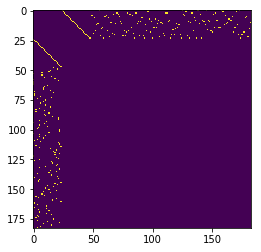

In [120]:
plt.imshow(adj_)

# 4. attribute와 relation 모두 빼기

In [121]:
dataset = 'vg_coco'
if dataset == 'vg_coco':
    sg_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg.pkl'
    sg = pickle.load(open(sg_path, 'rb'))
    out_path = '/data/project/rw/CBIR/data/vg_coco/vg_coco_sgg_obj.pkl'

In [122]:
print(len(sg))
print(sg[0].keys())

48220
dict_keys(['obj_bboxes', 'obj_attributes', 'edge_labels', 'num_objs', 'num_rels', 'obj_labels', 'adj', 'node_labels', 'imgid'])


In [123]:
new_sg = copy.deepcopy(sg)

In [124]:
for i, sg_ in enumerate(tqdm(sg)):
    n_obj = len(sg_['obj_bboxes'])
    n_attr = len(sg_['obj_attributes'])
    adj = sg_['adj']
    adj_ = sg_['adj'].copy()
    
    for i_rel in range(n_obj + n_attr, len(adj)):
        out_idx = np.argmax(adj[i_rel])
        in_idx = np.argmax(adj[:,i_rel])
        adj_[in_idx][out_idx] = 1
    
    a = np.delete(adj_, np.s_[n_obj:len(adj)], axis=1)
    new_adj = np.delete(a, np.s_[n_obj:len(adj)], axis=0)

    new_sg[i]['adj'] = new_adj
    new_sg[i]['node_labels'] = sg_['node_labels'][:n_obj]

100%|██████████| 48220/48220 [00:53<00:00, 895.98it/s] 


In [125]:
pickle.dump(new_sg, open(out_path, 'wb'))